# ASCAT_CCF calculation in sarcoma sample

In [1]:
# Needed basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [3]:
# Import filtered mutation files 
common_mut_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_List_common_mutations_callers.tsv.gz', sep="\t", header=0)

# Import purity value and copy number from ASCAT files
ascat_purity_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/ascat/AX4967_vs_AB9766/AX4967_vs_AB9766.purityploidy.txt', sep="\t", header=0)
ascat_cnv_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/ascat/AX4967_vs_AB9766/AX4967_vs_AB9766.cnvs.txt', sep="\t", header=0)

In [4]:
common_mut_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,124,46,0,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,126,69,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,141,6,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,153,45,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,123,90,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T


In [5]:
# Extract purity value from table, note that this value is the Aberrant Cell Fraction
purity = ascat_purity_df['AberrantCellFraction']
purity

0    0.6
Name: AberrantCellFraction, dtype: float64

## 1/ Processing ASCAT CNV file

In [6]:
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor
0,1,809641,14842839,2,0
1,1,14844137,15712384,4,0
2,1,15715111,21695683,2,0
3,1,21707894,21727934,2,1
4,1,21729424,26321837,2,2


In [7]:
# Calculate copy number (CN) from cnv files and add it as new column (CN is the sum of nMajor and nMinor columns)
ascat_cnv_df[['nMajor', 'nMinor']] = ascat_cnv_df[['nMajor', 'nMinor']].astype(int) # convert so it is operable, not string
ascat_cnv_df['CN'] = ascat_cnv_df['nMajor'] + ascat_cnv_df['nMinor'] # CN is the sum of nMajor and nMinor alleles
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor,CN
0,1,809641,14842839,2,0,2
1,1,14844137,15712384,4,0,4
2,1,15715111,21695683,2,0,2
3,1,21707894,21727934,2,1,3
4,1,21729424,26321837,2,2,4


In [8]:
# Add "chr" in chr column to homogenize nomenclature as common_mut_df 
ascat_cnv_df['chr'] = ascat_cnv_df['chr'].apply(lambda x: 'chr'+str(x))
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor,CN
0,chr1,809641,14842839,2,0,2
1,chr1,14844137,15712384,4,0,4
2,chr1,15715111,21695683,2,0,2
3,chr1,21707894,21727934,2,1,3
4,chr1,21729424,26321837,2,2,4


In [9]:
# Rename columns and drop unnecessary columns
ascat_cnv_df = ascat_cnv_df.rename(columns={'chr':'chrom','startpos':'start', 'endpos':'end'})
ascat_cnv_df = ascat_cnv_df.drop(columns=['nMajor','nMinor'])
ascat_cnv_df.head()

,chrom,start,end,CN
0,chr1,809641,14842839,2
1,chr1,14844137,15712384,4
2,chr1,15715111,21695683,2
3,chr1,21707894,21727934,3
4,chr1,21729424,26321837,4


## 2/ Add CN from ASCAT CN file to common mutations df with Pybedtools

In [10]:
# Pybedtools package: see https://daler.github.io/pybedtools/main.html for documentation
# installed in the conda environment through terminal with: pip install pybedtools
# The path of BedTools has been modified in bashrc file to be able to execute pybedtools globally.
# Import package
import pybedtools

In [11]:
# To use pybedtools POS column of common_mut_df should have another coordenate like end position. To do so, duplicate the information of POS column and add +1:

mutations_df = pd.DataFrame({
    'CHROM': common_mut_df['CHROM'],
    'start': common_mut_df['POS'],
    'end': common_mut_df['POS'] + 1, # duplicate this column so it is considered a "bed file"
    'REF': common_mut_df['REF'],
    'ALT': common_mut_df['ALT']   
}) # take only necessary columns of common_mut_df to convert as a "bed" coordinate file

mutations_df

,CHROM,start,end,REF,ALT
0,chr1,104188,104189,C,A
1,chr1,843320,843321,G,A
2,chr1,1014876,1014877,G,T
3,chr1,1118520,1118521,C,T
4,chr1,1136548,1136549,G,T
...,...,...,...,...,...
24290,chrY,26654389,26654390,A,G
24291,chrY,56823266,56823267,G,A
24292,chrY,56842066,56842067,CT,AC
24293,chrY,56842087,56842088,T,C


### Use ASCAT CNV FILE to intersect with mutation data

In [12]:
# Convert previous dataframes to a BedTool object so data could be processed with pybedtools
mutations_bt = pybedtools.BedTool.from_dataframe(mutations_df)
ascat_cn_bt = pybedtools.BedTool.from_dataframe(ascat_cnv_df)

In [13]:
# Use intersect method of Bedtools to intersect tables (see https://daler.github.io/pybedtools/intersections.html)
cnv_bt = ascat_cn_bt.intersect(mutations_bt) #save intersect table into a new dataframe

In [14]:
# Convert cnv bedtool object into a dataframe. 
cnv_df = cnv_bt.to_dataframe(header=None) # Note that "chrom, start, end, name" columns are by default even using "header = None".
cnv_df

,chrom,start,end,name
0,chr1,843320,843321,2
1,chr1,1014876,1014877,2
2,chr1,1118520,1118521,2
3,chr1,1136548,1136549,2
4,chr1,1182738,1182739,2
...,...,...,...,...
24056,chrX,153089070,153089071,1
24057,chrX,153635439,153635440,1
24058,chrX,154335112,154335113,1
24059,chrX,154408562,154408563,1


In [15]:
# Rename columns of cnv dataframe
cnv_df = cnv_df.rename(columns={'chrom':'CHROM','start':'POS','end':'POS2','name':'CN'})

# Drop POS2 column, which is an artificial column we created previously
cnv_df = cnv_df.drop(columns='POS2')

In [16]:
# We are loosing this number of mutations with the intersect method (?!)
len(mutations_df) - len(cnv_df)

234

## 3/ Calculate CCF

In [17]:
# Merge intersect with common_mut_df adding left indicates: use only keys from left frame, preserve key order
mutations_cnv_df = pd.merge(common_mut_df,cnv_df,how='left')

In [18]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,46,0,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,NaN
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,69,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,2.0
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,6,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,2.0
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,45,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,2.0
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,90,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24290,chrY,26654389,.,A,G,864,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,41,0,19,57,0.683000,SNV,Strelka_SAGE,sarcoma,chrY_26654389_A_G,NaN
24291,chrY,56823266,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=487,411|29,27...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:456,0:2.167e-03:456:195,0:201,0:448,0:238,...",...,56,0,442,456,0.112450,SNV,Mutect_Strelka,sarcoma,chrY_56823266_G_A,NaN
24292,chrY,56842066,.,CT,AC,1323,PASS,LPS=6133;LPS_RC=42;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,75,0,169,290,0.305000,MNV,Mutect_SAGE,sarcoma,chrY_56842066_CT_AC,NaN
24293,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=241,235|34,34...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,68,0,181,295,0.273092,SNV,Mutect_Strelka,sarcoma,chrY_56842087_T_C,NaN


In [19]:
# Check in CN column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
nan_values = mutations_cnv_df[~mutations_cnv_df['CN'].isna()]
nan_values

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,69,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,2.0
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,6,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,2.0
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,45,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,2.0
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,90,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,2.0
5,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=136,140|23,19...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,42,0,109,167,0.278146,SNV,Mutect_Strelka,sarcoma,chr1_1182738_C_T,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24166,chrX,153089070,.,A,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=33,46|23,34;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:54,0:0.018:54:16,0:36,0:54,0:24,30,0,0",...,57,0,25,54,0.695122,SNV,Mutect_Strelka,sarcoma,chrX_153089070_A_T,1.0
24167,chrX,153635439,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,42|27,28;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:67,0:0.014:67:33,0:34,0:67,0:36,31,0,0",...,55,0,21,67,0.723684,SNV,Mutect_Strelka,sarcoma,chrX_153635439_C_A,1.0
24168,chrX,154335112,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=93,76|3,2;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:76,0:0.013:76:31,0:43,0:75,0:37,39,0,0",...,5,0,93,76,0.051020,SNV,Mutect_Strelka,sarcoma,chrX_154335112_C_A,1.0
24169,chrX,154408562,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=68,58|13,11;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:72,0:0.014:72:32,0:36,0:69,0:39,33,0,0",...,24,0,54,72,0.307692,SNV,Mutect_Strelka,sarcoma,chrX_154408562_C_T,1.0


In [20]:
# Add 2 in CN with NaN values, because these positions despite were not in the cnv file are diploid
mutations_cnv_df['CN'].fillna(2, inplace=True) 

# Convert columns to float so they are operable to calculate CCF
mutations_cnv_df[['VAF','CN']] = mutations_cnv_df[['VAF','CN']].astype(float)
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,46,0,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,2.0
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,69,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,2.0
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,6,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,2.0
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,45,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,2.0
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,90,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24290,chrY,26654389,.,A,G,864,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,41,0,19,57,0.683000,SNV,Strelka_SAGE,sarcoma,chrY_26654389_A_G,2.0
24291,chrY,56823266,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=487,411|29,27...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:456,0:2.167e-03:456:195,0:201,0:448,0:238,...",...,56,0,442,456,0.112450,SNV,Mutect_Strelka,sarcoma,chrY_56823266_G_A,2.0
24292,chrY,56842066,.,CT,AC,1323,PASS,LPS=6133;LPS_RC=42;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,75,0,169,290,0.305000,MNV,Mutect_SAGE,sarcoma,chrY_56842066_CT_AC,2.0
24293,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=241,235|34,34...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,68,0,181,295,0.273092,SNV,Mutect_Strelka,sarcoma,chrY_56842087_T_C,2.0


In [21]:
# Define a function that calculates CCF in each row from CN, purity and VAF values
def get_ccf(row):
    row = row['VAF'] * (purity * row['CN'] + (1 - purity) * 2) / purity
    return row

mutations_cnv_df['CCF'] = mutations_cnv_df.progress_apply(get_ccf, axis=1)

  0%|          | 0/24295 [00:00<?, ?it/s]

In [22]:
mutations_cnv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,0,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,2.0,1.333333
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,2.0,1.703704
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,2.0,0.147059
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,2.0,1.056338
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,2.0,2.068966


## 4/ Histograms representing CCF

In [23]:
# To represent in histogram, convert CCF values to list
ccf = mutations_cnv_df['CCF'].copy()  # Extract the 'CCF' column
ccf = pd.to_numeric(ccf, errors='coerce')  # Convert values to numeric, coerce errors
ccf

0        1.333333
1        1.703704
2        0.147059
3        1.056338
4        2.068966
           ...   
24290    2.276667
24291    0.374833
24292    1.016667
24293    0.910308
24294    0.143333
Name: CCF, Length: 24295, dtype: float64

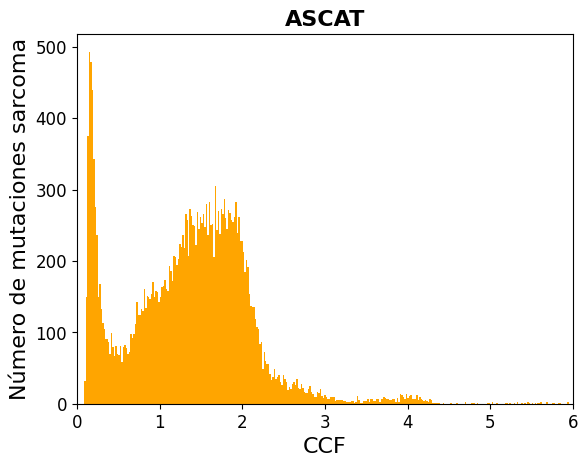

In [24]:
plt.hist(ccf.tolist(), bins = 400, color = 'orange')
plt.xlim([0,6])
plt.ylabel('Número de mutaciones sarcoma',  fontsize=16)
plt.xlabel('CCF', fontsize=16)
plt.title('ASCAT', fontsize=16, weight ='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_ccf_ascat_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(ccf.tolist())  